<a href="https://colab.research.google.com/github/Ok3ks/Disso-COLD/blob/main/Bert_20newsgroup_chunk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install transformers 
%pip install sklearn
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 101 kB 13.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.6 MB/s 
     |████████████████████████████████| 596 kB 95.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 77.4 MB/s 
     |████████████████████████████████| 115 kB 73.8 MB/s 
     |████████████████████████████████| 141 kB 86.2 MB/s 
     |████████████████████████████████| 127 kB 72.6 MB/s 
  Attempting uninstall: urllib3
  

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments,DataCollatorWithPadding
from datasets import load_dataset, load_metric,Dataset
import torch
import numpy as np
from utils import AssessData
from datasets import load_dataset
from utils import PrepareCorpus,AssessData
from sklearn.model_selection import train_test_split
from datasets import Dataset,load_dataset
import json
from re import template
from sklearn.model_selection import KFold

20 NEWSGROUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
parentdir = "/content/drive/MyDrive/ML/Datasets/20News"

train =parentdir+"/20news-bydate"+"/20news-bydate-train"
test = parentdir+"/20news-bydate"+ "/20news-bydate-test"

In [ ]:
id2labels = {'talk.politics.mideast': 0, 'rec.autos': 1, 'comp.sys.mac.hardware': 2, 'alt.atheism': 3, 'rec.sport.baseball': 4, 'comp.os.ms-windows.misc': 5, 'rec.sport.hockey': 6, 'sci.crypt': 7, 'sci.med': 8, 'talk.politics.misc': 9, 'rec.motorcycles': 10, 'comp.windows.x': 11, 'comp.graphics': 12, 'comp.sys.ibm.pc.hardware': 13, 'sci.electronics': 14, 'talk.politics.guns': 15, 'sci.space': 16, 'soc.religion.christian': 17, 'misc.forsale': 18, 'talk.religion.misc': 19}
id2classes = {'talk.politics.mideast': 0, 'rec.autos': 4, 'comp.sys.mac.hardware': 2, 'alt.atheism': 5, 'rec.sport.baseball': 1, 'comp.os.ms-windows.misc': 2, 'rec.sport.hockey': 1, 'sci.crypt': 3, 'sci.med': 3, 'talk.politics.misc': 0, 'rec.motorcycles': 4, 'comp.windows.x': 2, 'comp.graphics': 2, 'comp.sys.ibm.pc.hardware': 2, 'sci.electronics': 3, 'talk.politics.guns': 0, 'sci.space': 3, 'soc.religion.christian': 5, 'misc.forsale': 6, 'talk.religion.misc': 5}

number = range(50,150,50)
_per_segment = range(200,400,100)

overlap = {"side":"both", "number": 50}

f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")

def tokenize(batch):
    return bert_tokenizer(batch['text'], truncation=True, max_length=max_input_length,padding = True)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):
  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.00001,0.00005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)}

def bert_init():
  return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 7)

def id_2_labels(x,adict):
  """converts labels/classes into a number using a dictionary"""
  return adict[x]

def _indexing(alist):
  id = 0; indexed = {}
  for x in alist:
    for y in x:
      id +=1
      indexed[id] = y
  return indexed
  

In [ ]:
news_group_train = PrepareCorpus(train)
news_group_test = PrepareCorpus(test)

In [ ]:
news_group_test = news_group_test._prep()       #Keys are labels, values are texts
news_group_train = news_group_train._prep()

SELECTING TWO CLASSES

In [ ]:
#Selecting politics.mideast, politics.misc and sport.baseball, sport.hockey
labels = ['talk.politics.mideast', 'talk.politics.misc', 'talk.politics.guns', 'rec.sport.baseball','rec.sport.hockey']

temp_train = []; temp_test = []
temp_news_group_train = {}; temp_news_group_test = {}

for item in labels:
  temp_news_group_train[item] = news_group_train.get(item)
  temp_news_group_test[item] = news_group_test.get(item)

temp_train = _indexing(temp_news_group_train.values())
temp_test =  _indexing(temp_news_group_test.values())

temp_train_corpus = AssessData(temp_train, temp_news_group_train)
temp_test_corpus = AssessData(temp_test, temp_news_group_test)

In [ ]:
type(temp_train_corpus)

In [ ]:
temp_train_index_to_label = temp_train_corpus._index_to_label() 
temp_test_index_to_label = temp_test_corpus._index_to_label()

In [ ]:
temp_train_index_to_label = {i:id_2_labels(x,id2classes) for i,x in temp_train_index_to_label.items()}
temp_test_index_to_label = {i:id_2_labels(x,id2classes) for i,x in temp_test_index_to_label.items()}

In [ ]:
set(temp_train_index_to_label.values())

In [ ]:
temp_train_set = temp_train_corpus._chunk(200, overlap=overlap)
temp_train_index, temp_train_text = zip(*temp_train_set)

temp_test_set = temp_test_corpus._chunk(200, overlap=overlap)
test_index, test_text = zip(*temp_test_set)

In [ ]:
frac_train_set = {"train" : {"text": temp_train.values(), 'doc_id': temp_train_index_to_label.keys(), 'labels': temp_train_index_to_label.values()}}
frac_test_set =  {"test" : {"text": temp_test.values(), 'doc_id': temp_test_index_to_label.keys(), 'labels': temp_test_index_to_label.values()}}

In [ ]:
frac_train_set = Dataset.from_dict(frac_train_set['train'])
frac_test_set = Dataset.from_dict(frac_test_set['test'])

In [ ]:
frac_train_set = frac_train_set.map(tokenize)
frac_test_set = frac_test_set.map(tokenize)

frac_train_set = frac_train_set.shuffle(seed = 24)
frac_test_set = frac_test_set.shuffle(seed = 24)

In [ ]:
frac_test_set

In [ ]:
fold = KFold(n_splits = 5)
this_set = fold.split(frac_train_set['text'])

frac_fold_train = []; frac_fold_eval = []

for i,j in this_set:
  frac_fold_train.append(frac_train_set.select(i))
  frac_fold_eval.append(frac_train_set.select(j))

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 300)

#default training arguments 
training_args = TrainingArguments(output_dir="./frac_results", learning_rate=2e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=5,weight_decay=0.01)
results = []

#fine-tune
trainer = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= frac_fold_train[0],
                eval_dataset= frac_fold_eval[0],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2217
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train

Step,Training Loss
500,0.000000


Saving model checkpoint to ./frac_results/checkpoint-500
Configuration saved in ./frac_results/checkpoint-500/config.json
Model weights saved in ./frac_results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./frac_results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./frac_results/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=695, training_loss=1.6512689176484566e-06, metrics={'train_runtime': 348.1553, 'train_samples_per_second': 31.839, 'train_steps_per_second': 1.996, 'total_flos': 1709213327316000.0, 'train_loss': 1.6512689176484566e-06, 'epoch': 5.0})

In [ ]:
trainer_1 = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= frac_fold_train[1],
                eval_dataset= frac_fold_eval[1],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer_1.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2217
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 695
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation

Step,Training Loss
500,0.012800


Saving model checkpoint to ./frac_results/checkpoint-500
Configuration saved in ./frac_results/checkpoint-500/config.json
Model weights saved in ./frac_results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./frac_results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./frac_results/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=695, training_loss=0.009199816647585374, metrics={'train_runtime': 349.4964, 'train_samples_per_second': 31.717, 'train_steps_per_second': 1.989, 'total_flos': 1709213327316000.0, 'train_loss': 0.009199816647585374, 'epoch': 5.0})

In [ ]:
trainer_1.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 555
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_f1': {'f1': 1.0},
 'eval_loss': 1.2586773436851217e-06,
 'eval_precision': {'precision': 1.0},
 'eval_recall': {'recall': 1.0},
 'eval_runtime': 5.8363,
 'eval_samples_per_second': 95.095,
 'eval_steps_per_second': 5.997}

In [ ]:
trainer_2 = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= frac_fold_train[2],
                eval_dataset= frac_fold_eval[2],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer_2.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2218
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 695
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation

Step,Training Loss
500,0.004100


Saving model checkpoint to ./frac_results/checkpoint-500
Configuration saved in ./frac_results/checkpoint-500/config.json
Model weights saved in ./frac_results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./frac_results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./frac_results/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=695, training_loss=0.0029397173534778096, metrics={'train_runtime': 349.285, 'train_samples_per_second': 31.751, 'train_steps_per_second': 1.99, 'total_flos': 1709984285064000.0, 'train_loss': 0.0029397173534778096, 'epoch': 5.0})

In [ ]:
trainer_2.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 554
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_f1': {'f1': 1.0},
 'eval_loss': 3.483743000742834e-07,
 'eval_precision': {'precision': 1.0},
 'eval_recall': {'recall': 1.0},
 'eval_runtime': 5.8972,
 'eval_samples_per_second': 93.943,
 'eval_steps_per_second': 5.935}

In [ ]:
trainer_3 = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= frac_fold_train[3],
                eval_dataset= frac_fold_eval[3],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer_3.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2218
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 695
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation

Step,Training Loss
500,0.003200


Saving model checkpoint to ./frac_results/checkpoint-500
Configuration saved in ./frac_results/checkpoint-500/config.json
Model weights saved in ./frac_results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./frac_results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./frac_results/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=695, training_loss=0.002275791988505399, metrics={'train_runtime': 348.4291, 'train_samples_per_second': 31.829, 'train_steps_per_second': 1.995, 'total_flos': 1709984285064000.0, 'train_loss': 0.002275791988505399, 'epoch': 5.0})

In [ ]:
trainer_3.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 554
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_f1': {'f1': 1.0},
 'eval_loss': 6.382206265698187e-07,
 'eval_precision': {'precision': 1.0},
 'eval_recall': {'recall': 1.0},
 'eval_runtime': 5.8041,
 'eval_samples_per_second': 95.449,
 'eval_steps_per_second': 6.03}

In [ ]:
trainer_4 = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= frac_fold_train[3],
                eval_dataset= frac_fold_eval[3],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer_4.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2218
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 695
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation

Step,Training Loss
500,0.001400


Saving model checkpoint to ./frac_results/checkpoint-500
Configuration saved in ./frac_results/checkpoint-500/config.json
Model weights saved in ./frac_results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./frac_results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./frac_results/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=695, training_loss=0.0010128181141704027, metrics={'train_runtime': 348.5455, 'train_samples_per_second': 31.818, 'train_steps_per_second': 1.994, 'total_flos': 1709984285064000.0, 'train_loss': 0.0010128181141704027, 'epoch': 5.0})

In [ ]:
trainer_4.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 554
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Trainer is attempting to log a value of "{'f1': 1.0}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 1.0}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_f1': {'f1': 1.0},
 'eval_loss': 1.568655676464914e-07,
 'eval_precision': {'precision': 1.0},
 'eval_recall': {'recall': 1.0},
 'eval_runtime': 5.8146,
 'eval_samples_per_second': 95.278,
 'eval_steps_per_second': 6.019}

In [ ]:
trainer.predict(frac_test_set)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1846
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


PredictionOutput(predictions=array([[14.098028  , -1.4912723 , -3.5197954 , ..., -3.6451075 ,
        -3.5605521 , -3.6322472 ],
       [14.069137  , -1.2121682 , -3.6193976 , ..., -3.7079847 ,
        -3.6338902 , -3.6669984 ],
       [13.988607  , -0.47171164, -3.7710178 , ..., -3.8612034 ,
        -3.7816782 , -3.8226001 ],
       ...,
       [-1.0578972 , 14.913863  , -3.0020463 , ..., -3.1072378 ,
        -3.0268278 , -3.1448991 ],
       [-1.2890277 , 14.916755  , -2.948148  , ..., -3.0382755 ,
        -2.986302  , -3.0952275 ],
       [-1.289872  , 14.917773  , -2.9430904 , ..., -3.041633  ,
        -2.9744854 , -3.0983293 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.11893603950738907, 'test_f1': {'f1': 0.9913352020312788}, 'test_precision': {'precision': 0.9913472673073298}, 'test_recall': {'recall': 0.991332611050921}, 'test_runtime': 19.3655, 'test_samples_per_second': 95.324, 'test_steps_per_second': 5.99})

FULL TRAIN AND TEST DATA

In [ ]:
#Full train and test data

train_list_of_strings = _indexing(news_group_train.values())
test_list_of_strings = _indexing(news_group_test.values())

train_corpus = AssessData(train_list_of_strings, news_group_train)
test_corpus = AssessData(test_list_of_strings, news_group_test)

In [ ]:
train_index_to_label = train_corpus._index_to_label() 
test_index_to_label = test_corpus._index_to_label()

In [ ]:
train_index_to_label

In [ ]:
len(set(train_index_to_label.keys()))

11314

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_set = train_corpus._chunk(200, overlap=overlap)
train_index, train_text = zip(*train_set)

test_set = test_corpus._chunk(200, overlap=overlap)
test_index, test_text = zip(*test_set)

In [ ]:
train_index = {a:x-1 for a,x in enumerate(train_index)}
train_text = {a:x for a,x in enumerate(train_text)}

In [ ]:
type(train_chunked_label[100])

str

In [ ]:
test_index = {a:x-1 for a,x in enumerate(test_index)}
test_text = {a:x for a,x in enumerate(test_text)}

In [ ]:
train_chunked_label = {i:id_2_labels(x,train_index_to_label) for i,x in train_index.items()}
test_chunked_label = {i:id_2_labels(x,train_index_to_label) for i,x in test_index.items()}

In [ ]:
train_set = {"train" : {"text": train_text.values(), "doc_id": train_index.values(), "labels": train_chunked_label.values()}}
test_set =  {"test" : {"text": test_text.values(), 'doc_id': test_index.values(), 'labels': test_chunked_label.values()}}

In [ ]:
len(train_index.values()), len(train_text.values()), len(train_chunked_label.values())

(129646, 129646, 129646)

In [ ]:
import pandas as pd


a = pd.DataFrame(train_set['train'])
b = pd.DataFrame(test_set['test'])

In [ ]:
b

,text,doc_id,labels
0,From: Sang.Shin@launchpad.unc.edu (SANG SHIN)\...,0,talk.politics.guns
1,gy\n Nntp-Posting-Host: lambada.oit.unc.edu\n ...,0,talk.politics.guns
2,ack down his post for his name)\n was talking ...,0,talk.politics.guns
3,"h in. Thus, each link is a possible locking p...",0,talk.politics.guns
4,ore effective than kryptonite cable locks (IMH...,0,talk.politics.guns
...,...,...,...
81855,From: Patrick Pearse Gallagher <pg23+@andrew.c...,7531,comp.os.ms-windows.misc
81856,NNTP-Posting-Host: po3.andrew.cmu.edu\n In-Re...,7531,comp.os.ms-windows.misc
81857,"t injury, but since he has\n >beenback (and be...",7531,comp.os.ms-windows.misc
81858,"I beg to differ, he had a couple 3 hit games ...",7531,comp.os.ms-windows.misc


In [ ]:
#Maps 20 classes to 7 classes

a['labels'] = a['labels'].map(id2classes)
b['labels'] = b['labels'].map(id2classes)

In [ ]:
b

,text,doc_id,labels
0,From: Sang.Shin@launchpad.unc.edu (SANG SHIN)\...,0,0
1,gy\n Nntp-Posting-Host: lambada.oit.unc.edu\n ...,0,0
2,ack down his post for his name)\n was talking ...,0,0
3,"h in. Thus, each link is a possible locking p...",0,0
4,ore effective than kryptonite cable locks (IMH...,0,0
...,...,...,...
81855,From: Patrick Pearse Gallagher <pg23+@andrew.c...,7531,2
81856,NNTP-Posting-Host: po3.andrew.cmu.edu\n In-Re...,7531,2
81857,"t injury, but since he has\n >beenback (and be...",7531,2
81858,"I beg to differ, he had a couple 3 hit games ...",7531,2


In [ ]:
#Modify types

a['text'] = a['text'].astype(str)
a['doc_id'] = a['doc_id'].astype(int)
a['labels'] = a['labels'].astype(int)

b['text'] = b['text'].astype(str)
b['doc_id'] = b['doc_id'].astype(int)
b['labels'] = b['labels'].astype(int)

In [ ]:
train = Dataset.from_pandas(a)
test = Dataset.from_pandas(b)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train = train.map(tokenize)

  0%|          | 0/129646 [00:00<?, ?ex/s]

In [ ]:
test = test.map(tokenize)

  0%|          | 0/81860 [00:00<?, ?ex/s]

In [ ]:
train = train.shuffle(seed = 30)
test = test.shuffle(seed = 30)

In [ ]:
set(train['labels'])

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
from re import template
from sklearn.model_selection import KFold

fold = KFold(n_splits = 5)
this_set = fold.split(train['text'])

fold_train = []
fold_eval = []

for i,j in this_set:
  fold_train.append(train.select(i))
  fold_eval.append(train.select(j))

In [ ]:
%pip install optuna

In [36]:
training_args = TrainingArguments(output_dir="./results_temp", learning_rate=2e-5, per_device_train_batch_size=32, per_device_eval_batch_size=32, num_train_epochs=5,weight_decay=0.01)
results = []

max_input_length = 300

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 300)
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 7)

result = {}

#fine-tune
for i in range(len(fold_train)-1):
  trainer = Trainer(model = bert_model, 
                args = training_args,
                train_dataset= fold_train[i],
                eval_dataset= fold_eval[i],
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

  trainer.train()
  result[fold] = trainer.evaluate()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.888400
1000,0.650400
1500,0.622200
2000,0.587800
2500,0.559700
3000,0.529800
3500,0.474800
4000,0.411000
4500,0.396200
5000,0.396900


Saving model checkpoint to ./results_temp/checkpoint-500
Configuration saved in ./results_temp/checkpoint-500/config.json
Model weights saved in ./results_temp/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results_temp/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Saving model checkpoint to ./results_temp/checkpoint-1000
Configuration saved in ./results_temp/checkpoint-1000/config.json
Model weights saved in ./results_temp/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results_tem

Trainer is attempting to log a value of "{'f1': 0.8569251717504416}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8679177558339705}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8557269571924412}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transforme

Step,Training Loss
500,0.316800
1000,0.308600
1500,0.317500
2000,0.298600
2500,0.315700
3000,0.297500
3500,0.260000
4000,0.241100
4500,0.239200
5000,0.242400


Saving model checkpoint to ./results_temp/checkpoint-500
Configuration saved in ./results_temp/checkpoint-500/config.json
Model weights saved in ./results_temp/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results_temp/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Saving model checkpoint to ./results_temp/checkpoint-1000
Configuration saved in ./results_temp/checkpoint-1000/config.json
Model weights saved in ./results_temp/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results_tem

Trainer is attempting to log a value of "{'f1': 0.9222658494959324}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9341079895250561}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9200894751050946}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transforme

Step,Training Loss
500,0.222100


Saving model checkpoint to ./results_temp/checkpoint-500
Configuration saved in ./results_temp/checkpoint-500/config.json
Model weights saved in ./results_temp/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results_temp/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Step,Training Loss
500,0.222100
1000,0.224600
1500,0.223500
2000,0.225300
2500,0.233800
3000,0.224000
3500,0.209900
4000,0.202500
4500,0.196000
5000,0.208300


Saving model checkpoint to ./results_temp/checkpoint-1000
Configuration saved in ./results_temp/checkpoint-1000/config.json
Model weights saved in ./results_temp/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results_temp/checkpoint-1000/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Saving model checkpoint to ./results_temp/checkpoint-1500
Configuration saved in ./results_temp/checkpoint-1500/config.json
Model weights saved in ./results_temp/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./result

Trainer is attempting to log a value of "{'f1': 0.934695986240775}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9457526149958522}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9325851363338347}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, doc_id. If text, doc_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformer

Step,Training Loss


KeyboardInterrupt: ignored

In [37]:
result 

{KFold(n_splits=5, random_state=None, shuffle=False): {'epoch': 5.0,
  'eval_f1': {'f1': 0.934695986240775},
  'eval_loss': 0.17530567944049835,
  'eval_precision': {'precision': 0.9457526149958522},
  'eval_recall': {'recall': 0.9325851363338347},
  'eval_runtime': 301.1003,
  'eval_samples_per_second': 86.114,
  'eval_steps_per_second': 2.693}}

In [ ]:
with open("7_classes.json", "w") as ins:
  json.dump(result, ins)

In [ ]:
import json
with open ("eval_32_32", "w") as out: 
  json.dump(eval_32_32, out)

IMDB

In [ ]:
imdb = load_dataset("imdb")

Reusing dataset imdb (/Users/max/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████| 3/3 [00:00<00:00, 516.69it/s]


In [ ]:
train_imdb = imdb['train']
test_imdb = imdb['test']

In [ ]:
train_imdb_assess = AssessData(train_imdb['text'])
test_imdb_assess = AssessData(test_imdb['text'])

{'Too Long': 0, 'Long': 3012, 'BERT': 4759, 'Short': 17229}


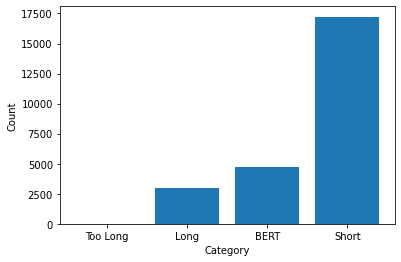

{'Too Long': 0, 'Long': 2803, 'BERT': 4639, 'Short': 17558}


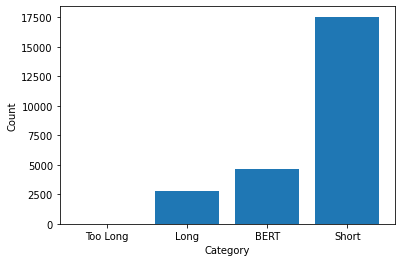

In [ ]:
train_imdb_assess._create_distribution()
train_imdb_assess._visualise()

test_imdb_assess._create_distribution()
test_imdb_assess._visualise()

In [ ]:
#Use cross_validation on test_data to tune model parameters